# Sensitivity analysis

In [14]:
from SALib.sample import saltelli, fast_sampler
from SALib.analyze import sobol, fast
from SALib.plotting.bar import plot as barplot
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

# function for reading csv files
def pd_read_pattern(pattern, sep):
    files = glob.glob(pattern)
    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f, sep=sep))
    return df.reset_index(drop=True)

# function to remove files
def removeFiles(pattern):
    files = glob.glob(pattern)
    for file in files:
        try:
            os.remove(file)
        except:
            print("Error while deleting file : ", file)

# read output files
def readOutput(read_raw_files, path, output_path, result_file_name):
    if (read_raw_files):
        df = pd_read_pattern(path + "group*.csv", sep=";")
        params = pd_read_pattern(path + "par*.csv", sep=";")
        params = params.drop(columns=["replicate"])
        df.iteration = df.iteration.astype(float)
        df = df.sort_values(by=['iteration'])
        df = pd.merge(df, params, on="iteration")
        df.to_csv(output_path + result_file_name + ".csv", index=False)
    else:
        df = pd.read_csv(output_path + result_file_name + ".csv")
    
    return df
        

In [15]:
# parameter dictionary
problem = {
    'num_vars': 3,
    'names': ['random-mating', 'leakage', 'fertility'],
    'bounds': [[0, 1],
               [0, 0.60],
               [0, 0.30]]
}

# Sobol

In [16]:
sample_parameters = False
if (sample_parameters):
    param_values = saltelli.sample(problem, 2**10)
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-sobol.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-sobol.csv")
len(t)

8192

In [17]:
df = readOutput(False, "../models/fertility-BMI/output/", "../output/data/", 
    "results-sobol")
# select valid iterations
df = df.loc[df["iteration"] <= len(t),:]
# define outcome
Y = df.g4.to_numpy()
len(Y)

8192

In [18]:
Si = sobol.analyze(problem, Y, print_to_console=True)

                     ST   ST_conf
random-mating  0.397389  0.073824
leakage        0.669998  0.083501
fertility      0.477098  0.105928
                     S1   S1_conf
random-mating  0.056838  0.048110
leakage        0.388196  0.076902
fertility      0.185499  0.054693
                                  S2   S2_conf
(random-mating, leakage)    0.088994  0.119655
(random-mating, fertility) -0.004479  0.077412
(leakage, fertility)       -0.014462  0.119918


In [19]:
total, first, second = Si.to_df()

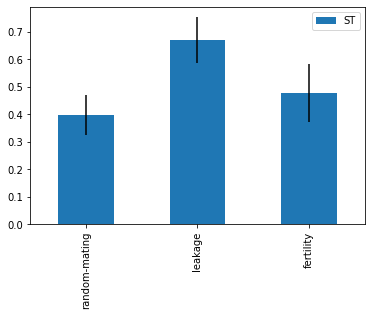

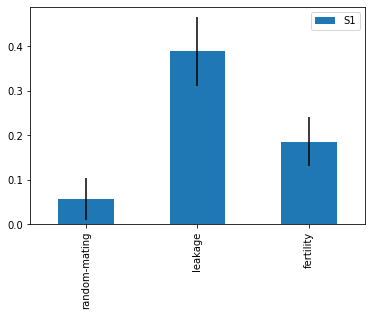

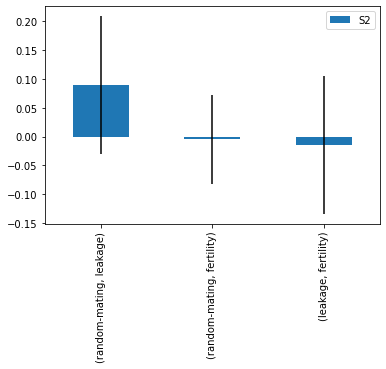

In [20]:
st = barplot(total)
plt.savefig("../output/plots/sobol-st.pdf", bbox_inches='tight')
s1 = barplot(first)
plt.savefig("../output/plots/sobol-s1.pdf", bbox_inches='tight')
s2 = barplot(second)
plt.savefig("../output/plots/sobol-s2.pdf", bbox_inches='tight')

In [24]:
fig = px.scatter_3d(df, x='random_mating', y='fertility_factor', z='leakage',
              color='g4', color_continuous_scale = px.colors.sequential.OrRd)

fig.update_traces(marker=dict(size=4, opacity = 0.4),
                  selector=dict(mode='markers'))
fig.update_layout(scene = dict(
                    xaxis_title='random mating',
                    yaxis_title='fertility',
                    zaxis_title='leakage'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10), 
                    coloraxis_colorbar=dict(title="Obese")
                    )
fig.show()

In [26]:
fig.write_image("../output/plots/3D-scatter-sobol.pdf")

# EFast

In [4]:

sample_parameters = False

if (sample_parameters):
    param_values = fast_sampler.sample(problem, 1000)
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-efast.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-efast.csv")

In [5]:
df = readOutput(False, "../models/fertility-BMI/output/", "../output/data/", 
    "results-efast")
df = df.loc[df["iteration"] <= len(t),:]
Y = df["g4"].to_numpy()
len(Y)

3000

In [6]:
df.g4.describe()

count    3000.000000
mean        0.377452
std         0.129322
min         0.000000
25%         0.300618
50%         0.349424
75%         0.421999
max         0.992259
Name: g4, dtype: float64

In [7]:
Sif = fast.analyze(problem, Y, print_to_console=True)

                     S1        ST   S1_conf   ST_conf
random-mating  0.070223  0.401014  0.008665  0.026893
leakage        0.372618  0.711972  0.007841  0.025028
fertility      0.175068  0.402974  0.006859  0.027998


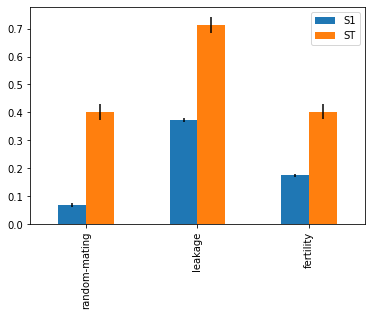

In [98]:
Sif.plot()
plt.savefig("../output/plots/efast.pdf", bbox_inches='tight')

In [11]:
fig = px.scatter_3d(df, x='random_mating', y='fertility_factor', z='leakage',
              color='g4', color_continuous_scale = px.colors.sequential.OrRd)

fig.update_traces(marker=dict(size=4, opacity = 0.7),
                  selector=dict(mode='markers'))
fig.update_layout(scene = dict(
                    xaxis_title='random mating',
                    yaxis_title='fertility',
                    zaxis_title='leakage'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10), 
                    coloraxis_colorbar=dict(title="Obese")
                    )
fig.show()

In [12]:
fig.write_image("../output/plots/3D-scatter-efast.pdf")